In [35]:
from underlying import Underlying
from option import Option
from trader import Trader

import matplotlib.pyplot as plt
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [36]:
def payoff_weird(X, K, p):
    return (1-p)*X.iloc[:,-1] * (X.iloc[:,-1] > K)

In [37]:
mu = 0.06
sigma =  0.3
r = 0.05
T = 1
X0 = 100
repeat = 100

## Full hedging - Vanilla Call

In [66]:
K = 80

In [67]:
underlying = Underlying(mu, sigma, r, 250)

In [68]:
_, reality = underlying.simulate_P(repeat, T)

In [69]:
option = Option(underlying, lambda X: payoff_weird(X, K, 0.9), T)
BS_Price = option.get_MC_price(X0, 0)

In [70]:
BS_Price

8.526481201885574

In [71]:
W, X = underlying.simulate_P(repeat,option.T)

In [72]:
data = pd.concat([W.iloc[:,-1],X.iloc[:,-1]], axis = 1)
data.columns = ['W','X']

In [73]:
data

,W,X
0,0.267589,1.099963
1,-0.415994,0.896015
2,2.160144,1.940689
3,-1.029154,0.745466
4,-0.602157,0.847345
...,...,...
95,-1.010459,0.749658
96,0.714884,1.257927
97,-0.209822,0.953185
98,1.211248,1.459910


In [74]:
data['dP/dQ*'] = (np.exp(
    (option.underlying.mu - option.underlying.r) * data['W'] / option.underlying.sigma +
    (0.5 * ((option.underlying.mu - option.underlying.r) / option.underlying.sigma) ** 2 +
     option.underlying.r) * option.T) * BS_Price / option.payoff_func(X * X0))
data = data.sort_values('dP/dQ*', ascending = False)

In [75]:
data

,W,X,dP/dQ*
99,-1.118155,0.725825,inf
15,-1.695406,0.610412,inf
41,-1.536765,0.640165,inf
39,-0.937609,0.766222,inf
56,-1.118495,0.725751,inf
...,...,...,...
24,1.713104,1.697118,0.559517
70,1.826577,1.755885,0.542840
62,1.920179,1.805890,0.529459
2,2.160144,1.940689,0.496639


In [76]:
data['dQ*/dP'] = 1/data['dP/dQ*']

In [77]:
data

,W,X,dP/dQ*,dQ*/dP
99,-1.118155,0.725825,inf,0.000000
15,-1.695406,0.610412,inf,0.000000
41,-1.536765,0.640165,inf,0.000000
39,-0.937609,0.766222,inf,0.000000
56,-1.118495,0.725751,inf,0.000000
...,...,...,...,...
24,1.713104,1.697118,0.559517,1.787254
70,1.826577,1.755885,0.542840,1.842162
62,1.920179,1.805890,0.529459,1.888722
2,2.160144,1.940689,0.496639,2.013534


In [78]:
hedge_prob = 0.7

In [79]:
boundary_index = ((data['dQ*/dP'].cumsum()/repeat) < hedge_prob).sum() - 1

In [80]:
boundary_index

81

In [81]:
data['dQ*/dP'].iloc[:boundary_index + 1].sum()/repeat

0.6935017771793247

In [82]:
phi = (hedge_prob - data['dQ*/dP'].iloc[:boundary_index + 1].sum()/repeat) / (data['dQ*/dP'].iloc[boundary_index + 1]/repeat)

In [83]:
phi

0.46553902660363217

In [84]:
data

,W,X,dP/dQ*,dQ*/dP
99,-1.118155,0.725825,inf,0.000000
15,-1.695406,0.610412,inf,0.000000
41,-1.536765,0.640165,inf,0.000000
39,-0.937609,0.766222,inf,0.000000
56,-1.118495,0.725751,inf,0.000000
...,...,...,...,...
24,1.713104,1.697118,0.559517,1.787254
70,1.826577,1.755885,0.542840,1.842162
62,1.920179,1.805890,0.529459,1.888722
2,2.160144,1.940689,0.496639,2.013534


In [85]:
k = data['dP/dQ*'].iloc[boundary_index + 1]

In [86]:
k

0.7164097622544386

In [87]:
data['phi'] = ((data['dP/dQ*'] > k)*1 + (data['dP/dQ*'] == k)*phi) * 1/repeat * data['dQ*/dP']

In [88]:
data['phi'].sum()

0.7

In [89]:
new_payoff = np.maximum(X0*data['X'] - K,0)* ((data['dP/dQ*'] > k)*1 + 0*(data['dP/dQ*'] == k)*phi)

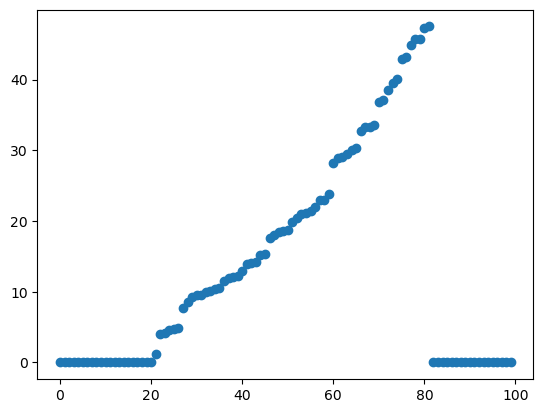

In [90]:
plt.scatter(range(reality.shape[0]),new_payoff)

In [91]:
new_payoff = np.maximum(X0*data['X'] - K,0)* ((data['dP/dQ*'] > k)*1 + (data['dP/dQ*'] == k)*phi)

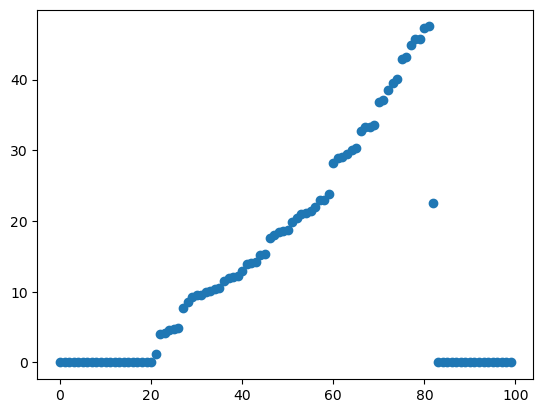

In [92]:
plt.scatter(range(reality.shape[0]),new_payoff)